In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np
from PIL import Image
import math
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
pd.set_option('display.max_colwidth', None)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Reshape

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
IMAGE_SIZE = 224
GRID_SIZE = 7
BATCH_SIZE = 16

In [4]:
DATA_PATH = '../data/LISATrafficLightDataset'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [5]:
DAY_TRAIN_PATH = '../data/LISATrafficLightDataset/Annotations/Annotations/dayTrain/'

In [6]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)

df = pd.concat([train_day_df],axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 96.27it/s]


In [7]:
df.head()

Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip1--00000.jpg             go                  698   
1  dayTraining/dayClip1--00000.jpg             go                  846   
2  dayTraining/dayClip1--00001.jpg             go                  698   
3  dayTraining/dayClip1--00001.jpg             go                  847   
4  dayTraining/dayClip1--00002.jpg             go                  698   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  333                   710                   358   
1                  391                   858                   411   
2                  337                   710                   357   
3                  390                   859                   410   
4                  331                   710                   356   

                                               Origin file  \
0  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
1  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
2  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
3  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
4  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   

   Origin frame number  \
0                    0   
1                    0   
2                    1   
3                    1   
4                    2   

                                              Origin track  \
0  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
1  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
2  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
3  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   
4  dayTraining/dayClip1/dayClip1Shutter0.000800-Gain-0.mp4   

   Origin track frame number  
0                          0  
1                          0  
2                          1  
3                          1  
4                          2

In [8]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [9]:
# Duplicate Columns
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [10]:
df = df.drop(['Annotation tag','Origin file','Origin track','Origin track frame number','Origin frame number'],axis=1)

In [11]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [12]:
df.columns = ['filename','x_min','y_min','x_max','y_max']

In [13]:
df

filename  \
0     ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
1     ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
2     ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
3     ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
4     ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg   
...                                                                                     ...   
1935  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip9/frames/dayClip9--00950.jpg   
1936  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip9/frames/dayClip9--00951.jpg   
1937  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip9/frames/dayClip9--00953.jpg   
1938  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip9/frames/dayClip9--00954.jpg   
1939  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip9/frames/dayClip9--00955.jpg   

      x_min  y_min  x_max  y_max  
0       698    333    710    358  
1       846    391    858    411  
2       698    337    710    357  
3       847    390    859    410  
4       698    331    710    356  
...     ...    ...    ...    ...  
1935    971    174   1067    314  
1936   1021    171   1099    306  
1937   1115    182   1199    299  
1938   1155    186   1260    294  
1939   1217    182   1280    294  

[37810 rows x 5 columns]

In [14]:
print("Number of Unique Images: ",df.filename.nunique(),'/',df.shape[0])

Number of Unique Images:  12775 / 37810


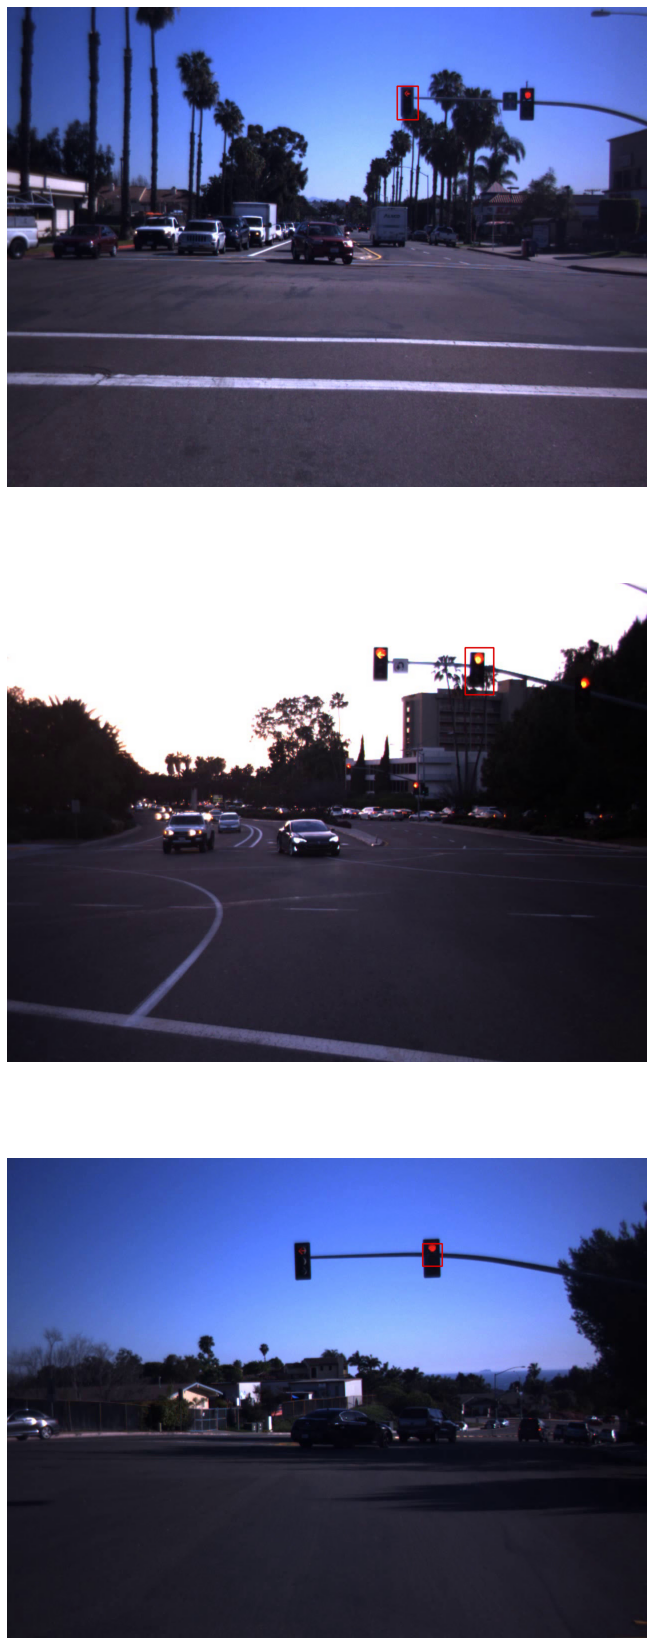

In [15]:
fig, ax = plt.subplots(3,1,figsize=(15,10*3))

for i in range(3):
    sample = df.sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.filename.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [16]:
df['clipNames'] = df[['filename']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

In [17]:
numbers = [2,3,6,8,9,11,13]
random_number = np.random.choice(numbers)
numbers.remove(random_number)
random_number2 = np.random.choice(numbers)
numbers.remove(random_number2)

In [18]:
def split(df):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames]

    testDayClipNames = list(['dayClip'+str(random_number), 'dayClip'+str(random_number2)])
    print(testDayClipNames)
    testClipNames = testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames = trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [19]:
train_df, test_df = split(df)

['dayClip6', 'dayClip2']


In [20]:
train_df.head()

filename  \
0  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
1  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
2  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
3  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
4  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg   

   x_min  y_min  x_max  y_max clipNames  
0    698    333    710    358  dayClip1  
1    846    391    858    411  dayClip1  
2    698    337    710    357  dayClip1  
3    847    390    859    410  dayClip1  
4    698    331    710    356  dayClip1

In [21]:
test_df.head()

filename  \
0  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg   
1  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg   
2  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg   
3  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg   
4  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip2/frames/dayClip2--00001.jpg   

   x_min  y_min  x_max  y_max clipNames  
0    902    242    929    287  dayClip2  
1   1220    334   1244    374  dayClip2  
2    754    243    784    288  dayClip2  
3    174    351    192    378  dayClip2  
4    902    240    929    289  dayClip2

In [22]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (34485, 6)
Test shape:  (3325, 6)


In [23]:
random_number = np.random.choice(numbers)
numbers.remove(random_number)
random_number2 = np.random.choice(numbers)
numbers.remove(random_number2)

In [24]:
train_df, val_df = split(train_df)
train_df.head()

['dayClip3', 'dayClip11']


filename  \
0  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
1  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg   
2  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
3  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg   
4  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg   

   x_min  y_min  x_max  y_max clipNames  
0    698    333    710    358  dayClip1  
1    846    391    858    411  dayClip1  
2    698    337    710    357  dayClip1  
3    847    390    859    410  dayClip1  
4    698    331    710    356  dayClip1

In [25]:
val_df.head()

filename  \
0  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip11/frames/dayClip11--00000.jpg   
1  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip11/frames/dayClip11--00000.jpg   
2  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip11/frames/dayClip11--00000.jpg   
3  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip11/frames/dayClip11--00001.jpg   
4  ../data/LISATrafficLightDataset\dayTrain/dayTrain/dayClip11/frames/dayClip11--00001.jpg   

   x_min  y_min  x_max  y_max  clipNames  
0    150    324    168    360  dayClip11  
1    233    334    245    352  dayClip11  
2    346    398    364    416  dayClip11  
3    152    323    170    354  dayClip11  
4    348    396    366    414  dayClip11

In [26]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (32094, 6)
Validation shape:  (2391, 6)


In [27]:
 train_df.filename.unique()

array(['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg',
       '../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg',
       '../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg',
       ...,
       '../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00953.jpg',
       '../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00954.jpg',
       '../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00955.jpg'],
      dtype=object)

In [28]:
train_df[['filename']].values

array([['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg'],
       ['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg'],
       ['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg'],
       ...,
       ['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00953.jpg'],
       ['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00954.jpg'],
       ['../data/LISATrafficLightDataset\\dayTrain/dayTrain/dayClip9/frames/dayClip9--00955.jpg']],
      dtype=object)

In [29]:
train_data = (train_df[['filename','x_min','y_min','x_max','y_max']].values)
val_data = (val_df[['filename','x_min','y_min','x_max','y_max']].values)
test_data = (test_df[['filename','x_min','y_min','x_max','y_max']].values)

In [30]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, shuffle=False):
        self.labels = data
        self.images = np.unique(self.labels[:,0])
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return (np.ceil(len(self.images) / int(BATCH_SIZE))).astype(int)
    
    def __getitem__(self, idx):
#         print(self.images[self.indexes])
        batch_x = self.images[self.indexes][idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # images path
#         batch_y = self.labels[idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # raw label
        
        train_image, train_label = [], []

        for i in range(0, len(batch_x)):
            img_path = batch_x[i]
            label = self.labels[self.labels[:,0] == img_path][:,1:5]
            
            image, label_matrix = self.read(img_path, label) #actual image array (IMAGE_SIZE, IMAGE_SIZE, 3) (GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + CLASS) 
            train_image.append(image)
            train_label.append(label_matrix)
        
#         if self.shuffle:
# #             np.random.shuffle(self.indexes)
#             indices = tf.range(start=0, limit=tf.shape(train_image)[0], dtype=tf.int32)
#             idx = tf.random.shuffle(indices)
#             train_image = tf.gather(train_image, idx)
#             train_label = tf.gather(train_label, idx)

        return np.array(train_image, dtype=np.float32), np.array(train_label, dtype=np.float32)
    
    def read(self, img_path, label):
        image = cv.imread(img_path)
        hp, wp = image.shape[0:2]
#         print(image.shape[0:2])
        image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image / 255.

#         label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + NUM_CLASS])
        label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5])

#         for l in label:
#         l = l.split(',')
#         l = np.array(l, dtype=int)

#         MERGE
        input = label
        for label in (input):
            h, w = hp, wp
    
#         indices = np.where(main_boxes[:, :, :, 0] == 1)

#         # Update merged grid with box values at the corresponding indices
#         merged_grid[indices[1], indices[2], 0] = 1
#         merged_grid[indices[1], indices[2], 1:5] = main_boxes[indices[0], indices[1], indices[2], 1:5]

            xmin, ymin, xmax, ymax = label[0] / w, label[1] / h, label[2] / w, label[3] / h # [0, 1]

            x, y = (xmin + xmax) / 2, (ymin + ymax) / 2
            w, h = xmax - xmin, ymax - ymin

            #convert x, y relative to the cell
            i, j = int(GRID_SIZE * y), int(GRID_SIZE * x)
            x = GRID_SIZE * x - j # 7 * [0,1] = [0, 7] e.g: 6.43 - int(6.43) = 0.43 => relative to the cell
            y = GRID_SIZE * y - i

            label_matrix[i, j] = [x, y, w, h, 1]
#             label_matrix[i, j] = [x, y, w, h, 1]
            
    #             if l[4] == 0:
    #                 label_matrix[i, j] = [x, y, w, h, 1, 1, 0]
    #             if l[4] == 1:
    #                 label_matrix[i, j] = [x, y, w, h, 1, 0, 1]

        return image, label_matrix
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            self.indexes = tf.random.shuffle(self.indexes)


In [31]:
# trainingDataGenerator = DataGenerator(X_train, y_train, shuffle=True)
# validationDataGenerator = DataGenerator(X_val, y_val)
# testDataGenerator = DataGenerator(X_test, y_test)

trainingDataGenerator = DataGenerator(train_data, shuffle=True)
# trainingDataGenerator = DataGenerator(train_data)
validationDataGenerator = DataGenerator(val_data)
testDataGenerator = DataGenerator(test_data)

In [32]:
def TestPrint(image, label):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_axis_off()

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i][j][4] > 0.2:
                print(label[i][j])
                x, y, w, h = label[i][j][:4]

                xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
                xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
                ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
                ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)

#                 className = classArray[tf.argmax(label[i][j][5:], axis=-1)]
#                 cv.putText(image, className, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
                cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 1), 1)

    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()
    
# def TestPrint(image, label):
#     fig, ax = plt.subplots()
#     ax.set_axis_off()

#     for i in range(GRID_SIZE):
#         for j in range(GRID_SIZE):
#             if label[i][j][0] > 0.2:
#                 print(label[i][j])
#                 x, y, w, h = label[i][j][1:5]

#                 xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
#                 xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
#                 ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
#                 ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)

#     #                 className = classArray[tf.argmax(label[i][j][5:], axis=-1)]
#     #                 cv.putText(image, className, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
#                 cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

#     ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
#     plt.show()

[0.6730469  0.5239583  0.02578125 0.06041666 1.        ]
[0.47148436 0.7317708  0.02109375 0.046875   1.        ]
[0.40664062 0.296875   0.02109375 0.04166667 1.        ]


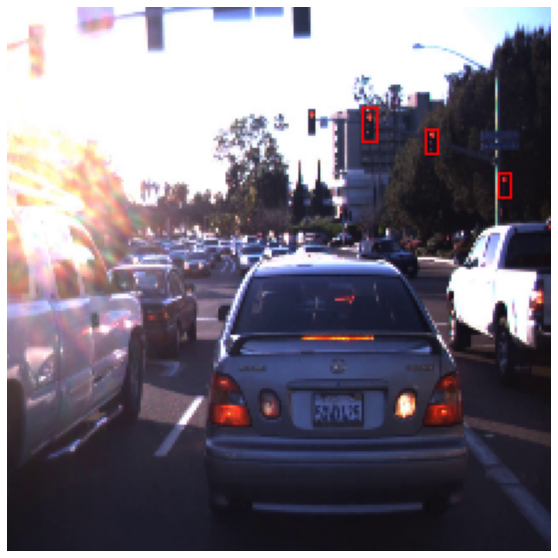

In [33]:
x_train_sample,y_train__sample = trainingDataGenerator.__getitem__(10)
idx = 3
TestPrint(x_train_sample[idx], y_train__sample[idx])

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np

# Load EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=trainingDataGenerator[0][0][0].shape)

for layer in base_model.layers:
    layer.trainable = False

# Add two more convolutional layers
x = base_model.output
x = Conv2D(filters=512, kernel_size=1, strides=(1, 1), activation='relu',  padding='same')(x)
x = Conv2D(filters=5, kernel_size=1, strides=(1, 1), activation='linear', padding='same')(x)
# x = Reshape(target_shape=(7, 7, 5))(x)

# Create a new model with modified output shape
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
# model.summary()

In [38]:
#YOLO LOSS !!!
def yoloLoss(y_true, y_pred):
    coordLoss = CoordLoss(y_true, y_pred)
    confidenceLoss = ConfidenceLoss(y_true, y_pred)
#     confidenceLoss = ConfidenceLoss(y_true, tf.math.sigmoid(y_pred))

    return coordLoss + 10*confidenceLoss 

def CoordLoss(y_true, y_pred):
    #find if it exist an object in the grid
    existsObject = tf.expand_dims(y_true[..., 4], -1)

    xy_pred = existsObject * y_pred[..., 0:2]
    xy_true = existsObject * y_true[..., 0:2]

    wh_pred = existsObject * tf.math.sign(y_pred[..., 2:4]) * tf.sqrt(tf.math.abs(y_pred[..., 2:4])) #if it's linear (-inf, inf)
    wh_true = existsObject * tf.sqrt(y_true[..., 2:4])

    coordLoss = tf.reduce_sum(tf.math.square(wh_pred - wh_true))
    coordLoss += tf.reduce_sum(tf.math.square(xy_pred - xy_true))

    return coordLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

def ConfidenceLoss(y_true, y_pred):
    existsObject = tf.math.sigmoid(tf.expand_dims(y_true[..., 4], -1))

    confidenceLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 4:5] - y_pred[..., 4:5])))
    confidenceLoss += 0.5*tf.reduce_sum(tf.math.square((1 - existsObject) * (y_true[..., 4:5] - y_pred[..., 4:5])))

    return confidenceLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't



# from keras import backend as K

# #YOLO LOSS !!!
# def yoloLoss(y_true, y_pred):
#     coordLoss = CoordLoss(y_true, y_pred)
#     confidenceLoss = ConfidenceLoss(y_true, y_pred)

#     return coordLoss + confidenceLoss 

# def CoordLoss(y_true, y_pred):
#     K.print_tensor(y_true, message="x is: ")
#     K.print_tensor(y_pred, message="y is: ")

#     #find if it exist an object in the grid
#     existsObject = tf.expand_dims(y_true[..., 0], -1)

#     xy_pred = existsObject * y_pred[..., 1:3]
#     xy_true = existsObject * y_true[..., 1:3]

#     wh_pred = existsObject * tf.math.sign(y_pred[..., 3:5]) * tf.sqrt(tf.math.abs(y_pred[..., 3:5])) #if it's linear (-inf, inf)
#     wh_true = existsObject * tf.sqrt(y_true[..., 3:5])

#     coordLoss = tf.reduce_sum(tf.math.square(wh_pred - wh_true))
#     coordLoss += tf.reduce_sum(tf.math.square(xy_pred - xy_true))

#     return coordLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

# def ConfidenceLoss(y_true, y_pred):
#     existsObject = tf.expand_dims(y_true[..., 0], -1)

#     confidenceLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 0:1] - y_pred[..., 0:1])))
#     confidenceLoss += 0.5*tf.reduce_sum(tf.math.square((1 - existsObject) * (y_true[..., 0:1] - y_pred[..., 0:1])))

#     return confidenceLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't


In [39]:
model.compile(loss = yoloLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy", CoordLoss, ConfidenceLoss]) 


In [37]:
model.fit(x = trainingDataGenerator, epochs = 5)

Epoch 1/5
652/652 [==============================] - 532s 802ms/step - loss: 0.2471 - accuracy: 0.2353 - CoordLoss: 0.2055 - ConfidenceLoss: 0.0417
Epoch 2/5
652/652 [==============================] - 462s 709ms/step - loss: 0.1241 - accuracy: 0.3501 - CoordLoss: 0.0981 - ConfidenceLoss: 0.0260
Epoch 3/5
652/652 [==============================] - 450s 690ms/step - loss: 0.1155 - accuracy: 0.3668 - CoordLoss: 0.0935 - ConfidenceLoss: 0.0220
Epoch 4/5
652/652 [==============================] - 490s 752ms/step - loss: 0.1139 - accuracy: 0.3683 - CoordLoss: 0.0934 - ConfidenceLoss: 0.0205
Epoch 5/5
652/652 [==============================] - 441s 675ms/step - loss: 0.1120 - accuracy: 0.3711 - CoordLoss: 0.0920 - ConfidenceLoss: 0.0199


In [40]:
model.fit(  x = trainingDataGenerator,
            validation_data = (validationDataGenerator),
            epochs = 5,
            validation_freq = 3
            )

Epoch 1/5
652/652 [==============================] - 402s 605ms/step - loss: 0.4644 - accuracy: 0.4429 - CoordLoss: 0.1013 - ConfidenceLoss: 0.0363
Epoch 2/5
652/652 [==============================] - 423s 649ms/step - loss: 0.2610 - accuracy: 0.4087 - CoordLoss: 0.0900 - ConfidenceLoss: 0.0171
Epoch 3/5
652/652 [==============================] - 475s 728ms/step - loss: 0.2654 - accuracy: 0.4209 - CoordLoss: 0.0902 - ConfidenceLoss: 0.0175 - val_loss: 0.4902 - val_accuracy: 0.5096 - val_CoordLoss: 0.1559 - val_ConfidenceLoss: 0.0335
Epoch 4/5
652/652 [==============================] - 414s 635ms/step - loss: 0.2429 - accuracy: 0.4505 - CoordLoss: 0.0883 - ConfidenceLoss: 0.0155
Epoch 5/5
 12/652 [..............................] - ETA: 6:30 - loss: 0.2506 - accuracy: 0.2953 - CoordLoss: 0.0909 - ConfidenceLoss: 0.0160

KeyboardInterrupt: 

In [41]:
accuracy = model.evaluate(testDataGenerator)

# Print the model's accuracy on the validation or test set
print('Accuracy:', accuracy[3])

86/86 [==============================] - 55s 640ms/step - loss: 0.4605 - accuracy: 0.2903 - CoordLoss: 0.1871 - ConfidenceLoss: 0.0275
Accuracy: 0.027519838884472847


1/1 [==============================] - 1s 1s/step
[0.4015111  0.4930537  0.02638106 0.05398876 0.21557151]
[0.28216758 0.39100325 0.03324801 0.07289802 0.8932024 ]
[0.26649    0.44498453 0.02676559 0.0682712  0.878293  ]
[0.22754759 0.7250137  0.02698034 0.07175694 0.5632039 ]
[0.55088925 0.5280224  0.0166997  0.03728292 0.2133394 ]
[0.4211288  0.538395   0.01992328 0.04702733 0.3503829 ]
[0.38635796 0.4008324  0.01625844 0.04193647 0.2837676 ]
[12.573548   -7.002797   -6.8131638  -3.7796876   0.36603484]


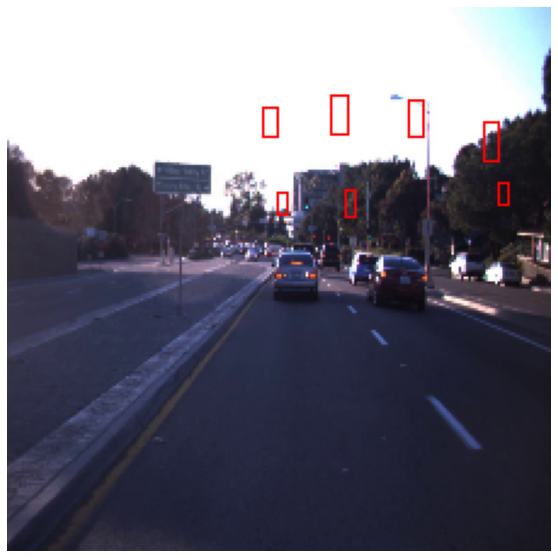

1/1 [==============================] - 0s 59ms/step
[0.40136242 0.49319243 0.02639017 0.05399886 0.21568766]
[0.28169987 0.39075786 0.03327246 0.07295171 0.8951466 ]
[0.26555133 0.44455713 0.02680637 0.06839646 0.8817691 ]
[0.22696483 0.7254177  0.02692329 0.07167881 0.56382585]
[0.550863   0.528339   0.01671025 0.03728606 0.21354695]
[0.42028946 0.5380457  0.01999176 0.04718049 0.35571003]
[0.38508636 0.4017602  0.01628733 0.04195675 0.28599972]
[12.565632  -6.997805  -6.8080244 -3.7783487  0.3651677]


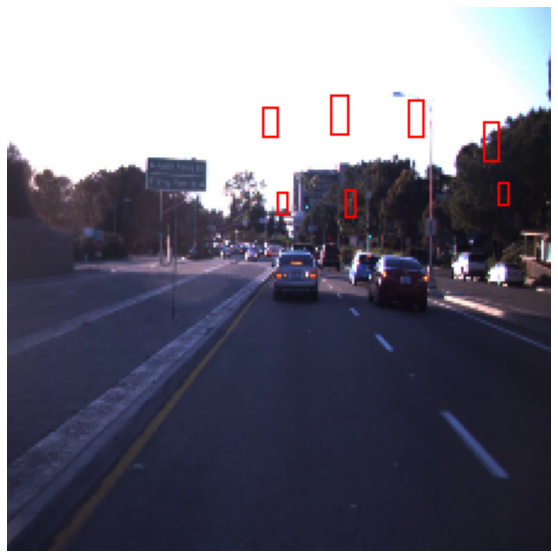

1/1 [==============================] - 0s 53ms/step
[0.40139872 0.49338374 0.02639178 0.05401199 0.21608792]
[0.2817998  0.39076185 0.0332553  0.07292952 0.8946261 ]
[0.2651573  0.44370383 0.02680764 0.06844801 0.8835022 ]
[0.22698963 0.7242126  0.02691177 0.07162497 0.56323344]
[0.55123204 0.52859616 0.01670566 0.03727669 0.2137781 ]
[0.4206601  0.53843415 0.0199645  0.04712581 0.35349676]
[0.38550943 0.4006153  0.01628217 0.0419203  0.2858988 ]
[12.562007  -6.997113  -6.8076153 -3.7775483  0.3649301]


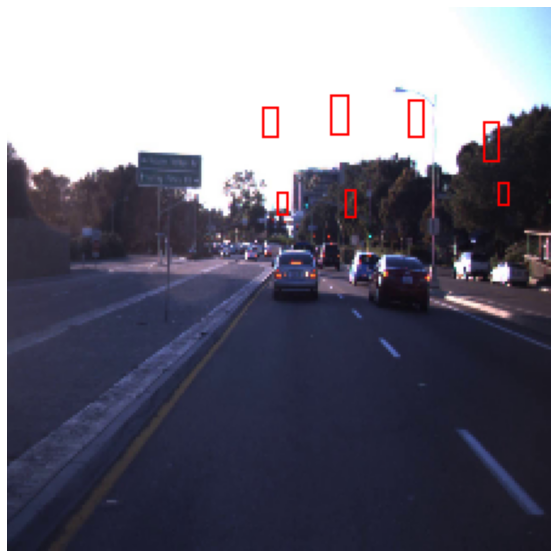

1/1 [==============================] - 0s 56ms/step
[0.40195885 0.49385172 0.02634585 0.0539226  0.21342446]
[0.2827735  0.39128172 0.03317812 0.07276067 0.88980216]
[0.26605895 0.44395733 0.02673532 0.06830145 0.88      ]
[0.22748661 0.7237472  0.02686825 0.07158637 0.56261677]
[0.55179554 0.52854955 0.01668784 0.03724754 0.21341716]
[0.4215514  0.5389135  0.01989317 0.0469703  0.34766823]
[0.38584244 0.39955217 0.01621949 0.04184963 0.28500095]
[12.57531    -7.002212   -6.8164234  -3.7784555   0.36499795]


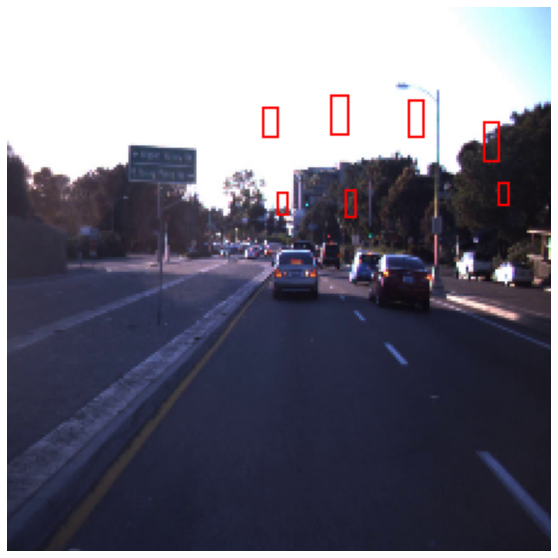

1/1 [==============================] - 0s 57ms/step
[0.40199414 0.49403226 0.02633969 0.05389868 0.21291046]
[0.28267094 0.39129627 0.03319138 0.07278268 0.89044356]
[0.26583147 0.44389573 0.02676223 0.06834662 0.88135076]
[0.22744647 0.72399205 0.02689073 0.07160625 0.56261325]
[0.55136687 0.5287814  0.01668263 0.03723875 0.21233267]
[0.4213572  0.53896403 0.01992319 0.04703476 0.3495587 ]
[0.3861016  0.39928448 0.01620664 0.04185673 0.28475007]
[12.578158   -7.003468   -6.8180256  -3.778792    0.36525816]


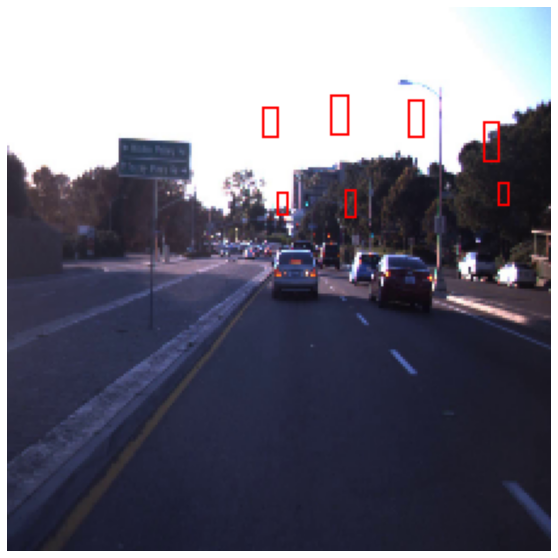

1/1 [==============================] - 0s 56ms/step
[0.40299162 0.47683755 0.02484339 0.05091295 0.20263764]
[0.40209594 0.49408096 0.02633077 0.0538722  0.21224444]
[0.28238836 0.39120203 0.03321836 0.07284446 0.8923368 ]
[0.26525468 0.443725   0.02680369 0.06844318 0.8843763 ]
[0.22742566 0.7237018  0.02691228 0.07157822 0.5628758 ]
[0.5510321  0.5287879  0.01667395 0.03722534 0.21138306]
[0.42130607 0.53910625 0.01993818 0.04705934 0.35014573]
[0.38612276 0.39918038 0.01621394 0.04185609 0.28480515]
[12.574703  -7.002562  -6.8137455 -3.7792397  0.3658045]


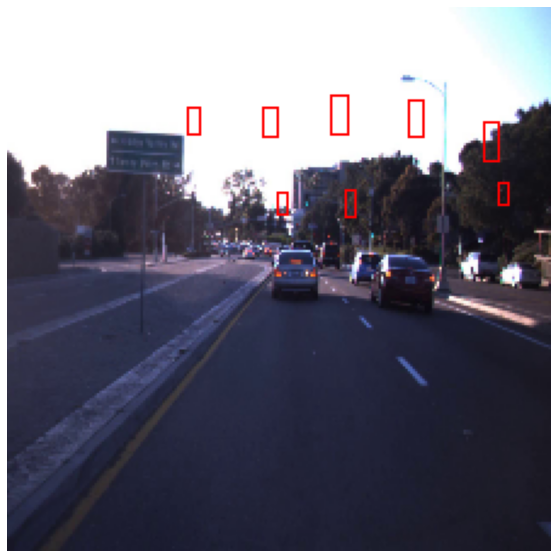

1/1 [==============================] - 0s 56ms/step
[0.40181506 0.47548538 0.02490824 0.05110566 0.21010546]
[0.40249407 0.4942741  0.02629363 0.05378527 0.21010442]
[0.28256422 0.3908031  0.03318119 0.07278314 0.8916053 ]
[0.26433912 0.44180363 0.02676284 0.06843028 0.8874638 ]
[0.22758773 0.72300434 0.02688708 0.07152842 0.56297034]
[0.55111444 0.5286546  0.01665873 0.03719754 0.21045813]
[0.42160174 0.5390256  0.01990222 0.04700091 0.3474266 ]
[0.38627025 0.3987605  0.01619432 0.04184044 0.2850257 ]
[12.57937   -7.0075426 -6.816534  -3.780276   0.3670688]


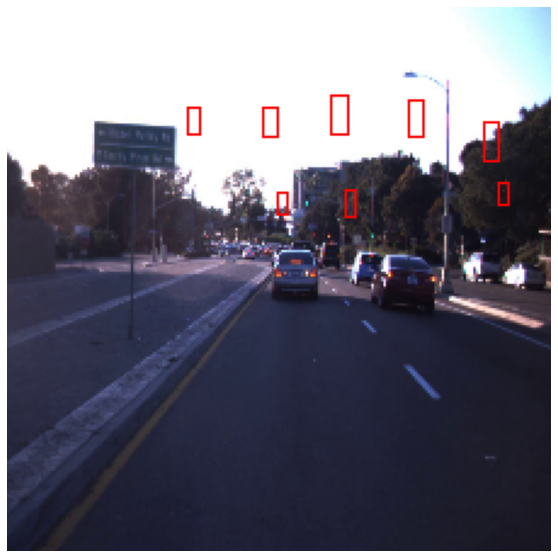

1/1 [==============================] - 0s 61ms/step
[0.40218037 0.47547847 0.02484778 0.05099674 0.20765294]
[0.40320116 0.49464923 0.02624379 0.05365878 0.20607516]
[0.2833769  0.3915662  0.0331436  0.07268658 0.88795084]
[0.2658243  0.443847   0.02676638 0.06835623 0.8827891 ]
[0.22771022 0.7237461  0.0268977  0.07151364 0.56275356]
[0.55015945 0.5287506  0.01662384 0.03715096 0.20783211]
[0.421916   0.5393288  0.01990405 0.0469764  0.34699345]
[0.38607866 0.3996188  0.01618618 0.04185776 0.2845238 ]
[12.579575  -7.0073214 -6.81676   -3.780023   0.367109 ]


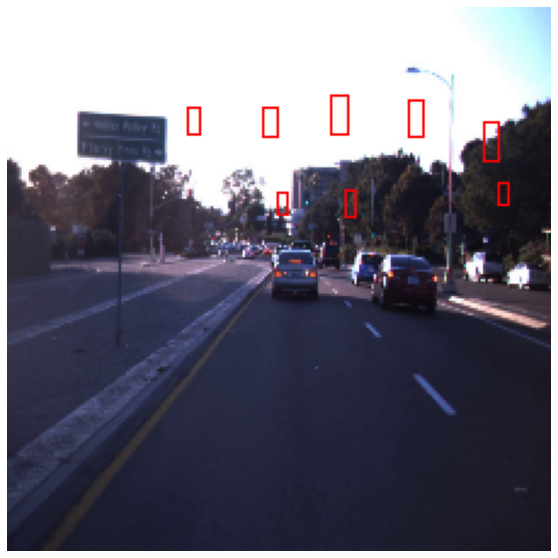

1/1 [==============================] - 0s 51ms/step
[0.40127933 0.47334498 0.02481191 0.05102553 0.2099456 ]
[0.28425065 0.39177525 0.03306919 0.07253626 0.8834298 ]
[0.2663542  0.44359517 0.02673212 0.0682855  0.881072  ]
[0.22813252 0.7235401  0.02684803 0.07145446 0.561495  ]
[0.55012697 0.5284746  0.0165525  0.03704459 0.20401776]
[0.42285967 0.53955466 0.0198182  0.04679798 0.34055775]
[0.38662508 0.39982927 0.01613324 0.0418506  0.28273946]
[12.592176   -7.014374   -6.8249207  -3.7814724   0.36846787]


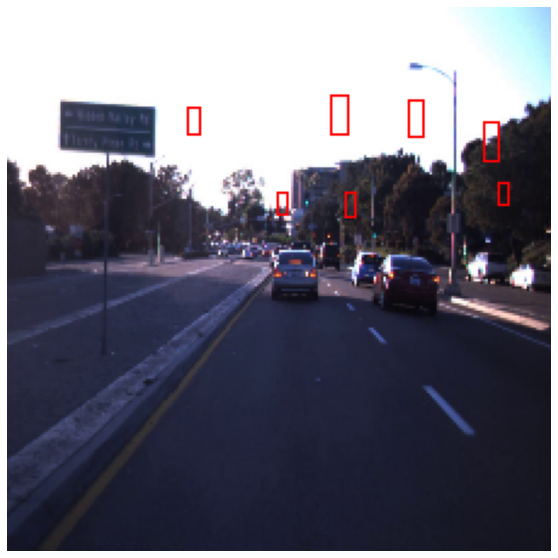

In [42]:
for i in range(9):
    image = cv.imread('../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--0000' + str(i) + '.jpg')
    image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     image = image / 255
    image = (image / 255).astype(np.float32)

    TestPrint(image, model.predict(np.expand_dims(image, 0))[0])

In [43]:
def TestPrint_1(image, label):
    fig, ax = plt.subplots()
    ax.set_axis_off()

    boxes = []
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i][j][4] > 0.2:
                x, y, w, h = label[i][j][:4]
                xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
                xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
                ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
                ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)
                confidence = label[i][j][4]
                boxes.append([xmin, ymin, xmax, ymax, confidence])

    # apply non-maximum suppression
    nms_boxes = []
    while len(boxes) > 0:
        max_conf_idx = np.argmax(np.array(boxes)[:, 4])
        box = boxes[max_conf_idx]
        nms_boxes.append(box)
        boxes.pop(max_conf_idx)
        for b in boxes:
            if iou(box, b) > 0.2:
                boxes.remove(b)

    # draw boxes after nms
    for box in nms_boxes:
        xmin, ymin, xmax, ymax, confidence = box
#         cv.putText(image, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

def iou(box1, box2):
    # box1: [xmin, ymin, xmax, ymax]
    # box2: [xmin, ymin, xmax, ymax]
    x1, y1, x2, y2 = box1[:4]
    x3, y3, x4, y4 = box2[:4]
    xi1 = max(x1, x3)
    yi1 = max(y1, y3)
    xi2 = min(x2, x4)
    yi2 = min(y2, y4)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


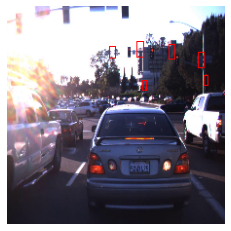

In [44]:
x_train, y_train = trainingDataGenerator.__getitem__(1)
idx = 0
# for i in range(9):
#     image = cv.imread('images/Cats_Test20' + str(i) + '.png')
#     image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     image = image / 255.
TestPrint_1(x_train[idx], model.predict(np.expand_dims(x_train[idx], 0))[0])
    


In [ ]:
model.predict(np.expand_dims(x_train_sample[idx], 0))[0][5][5]